# Project: Prediksi Tingkat Obesitas (Klasifikasi 7 Kelas)
**Problem statement**  
Tujuan: Memprediksi tingkat obesitas (7 kelas pada kolom `NObeyesdad`) untuk **mendeteksi risiko obesitas sejak dini** sehingga orang awam dapat memahami risikonya dan melakukan tindakan pencegahan.

**Pengguna target:** orang awam (bukan tenaga medis).  
**Output yang diharapkan:** model klasifikasi 7 kelas + penjelasan interpretasi sederhana untuk pengguna (mis. "Risiko: Overweight_Level_I — saran: kurangi gula & olahraga 30 menit/hari").

**Catatan dataset:** https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# **2. Memuat Dataset**

In [2]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
# df = df.drop(columns=['Height', 'Weight'])

## 2.1 Melihat 5 data teratas

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## 2.2 Melihat informasi mengenai dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

## 2.3 Menampilkan statistik deskriptif dataset

In [5]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## 2.4 Mengecek apakah terdapat missing value atau duplikat data

### 2.4.1 Mengecek Missing Value

In [6]:
missing_values = df.isnull().sum()
print(f"Banyaknya missing value pada setiap kolom:\n{missing_values}")

Banyaknya missing value pada setiap kolom:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


### 2.4.2 Mengecek Data Duplikat

In [7]:
duplicated_rows = df.duplicated().sum()
print(f"Banyaknya data duplikat: {duplicated_rows}")

Banyaknya data duplikat: 24


Kesimpulannya tidak ada data yang hilang, namun terdapat data yang duplikat sebanyak 24

In [8]:
df.drop_duplicates(inplace=True)
print(f"Banyaknya data duplikat: {duplicated_rows}")

Banyaknya data duplikat: 24


## 2.5 Mengecek Outlier

### 2.5.1 Mengecek jumlah outlier pada data numerik

In [9]:
df_numeric = df.select_dtypes(include=[np.number])
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outlier_count = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()
print(f"Banyaknya outlier pada setiap kolom numerik:\n{outlier_count}")

Banyaknya outlier pada setiap kolom numerik:
Age       167
Height      1
Weight      1
FCVC        0
NCP       577
CH2O        0
FAF         0
TUE         0
dtype: int64


### 2.5.2 Visualisasi Outliers

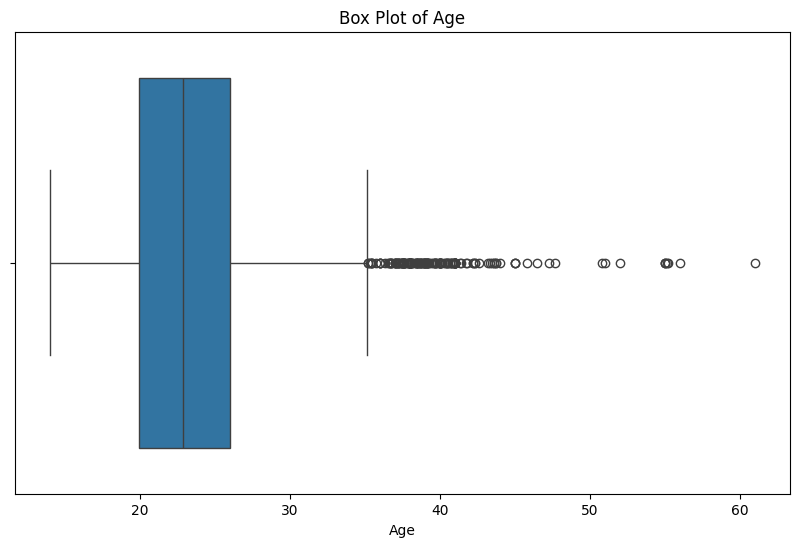

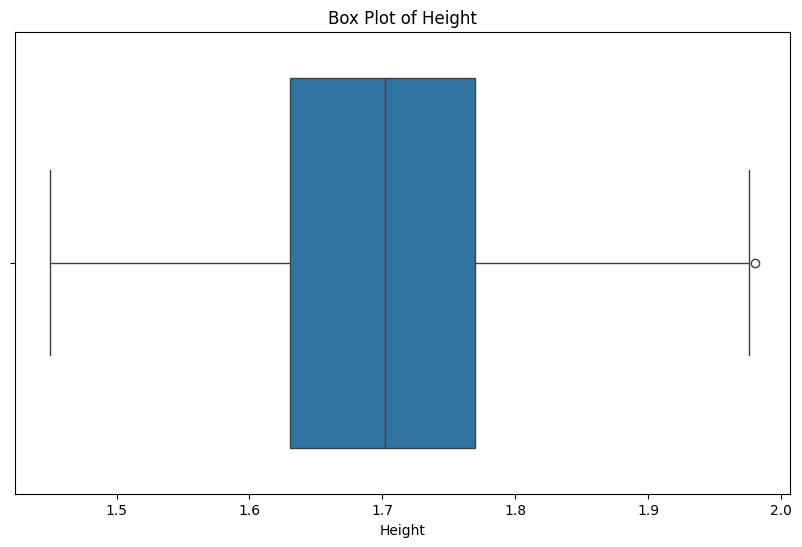

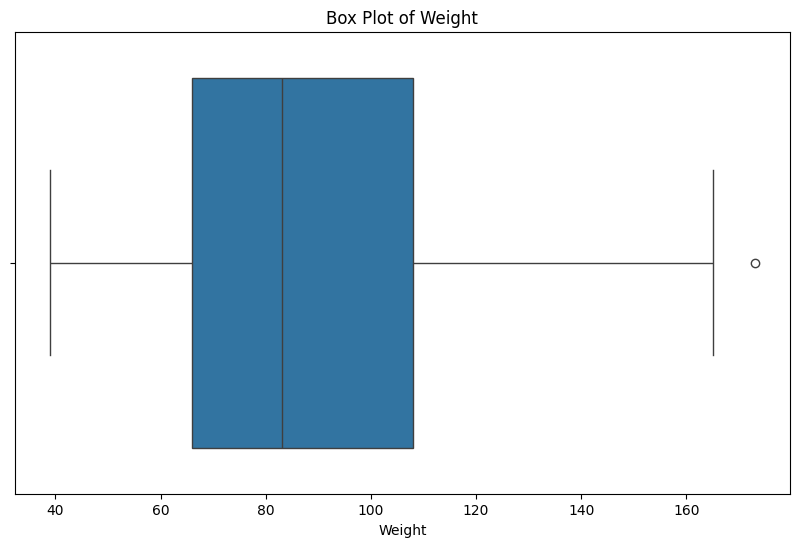

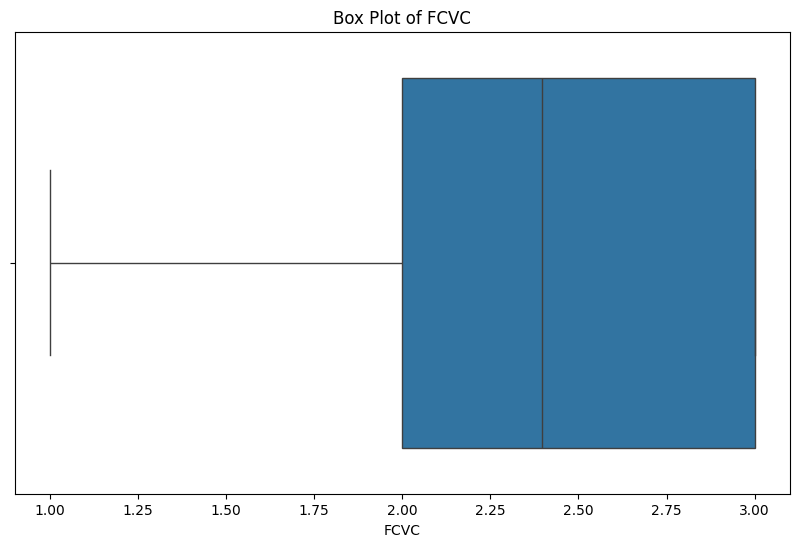

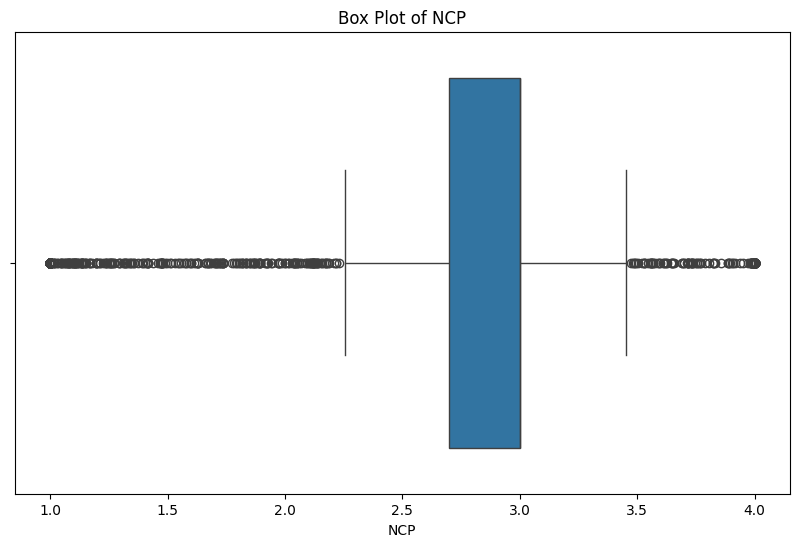

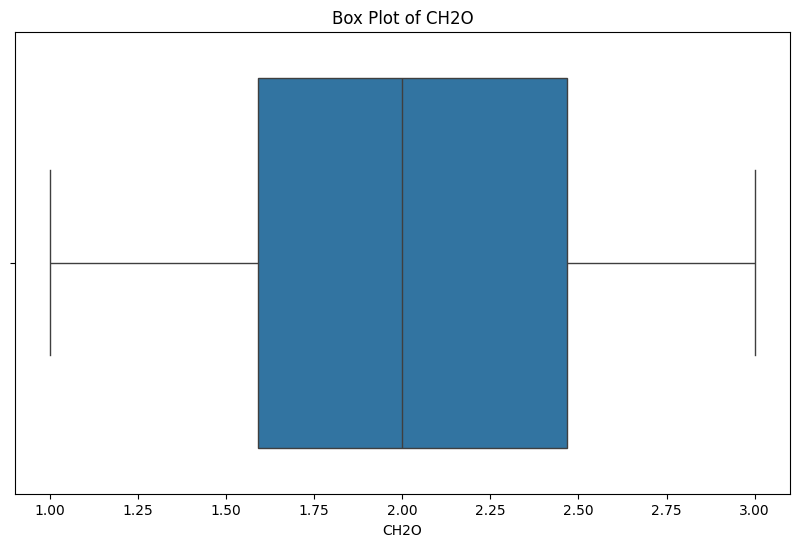

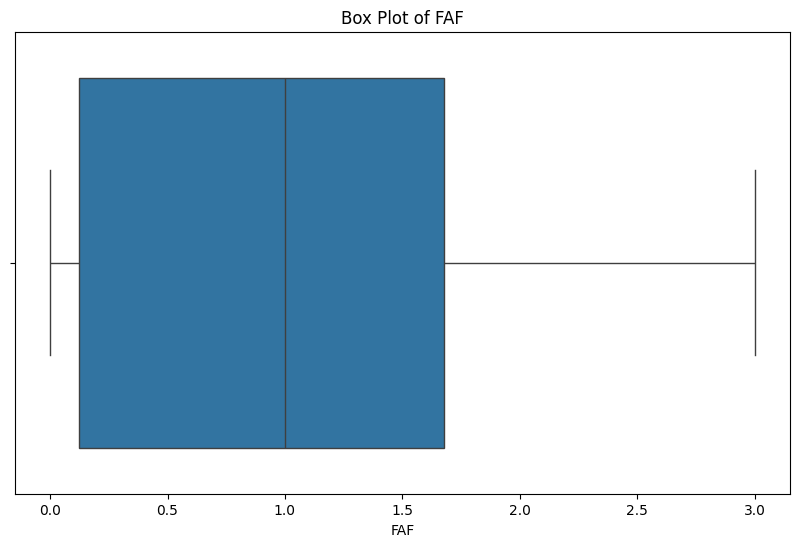

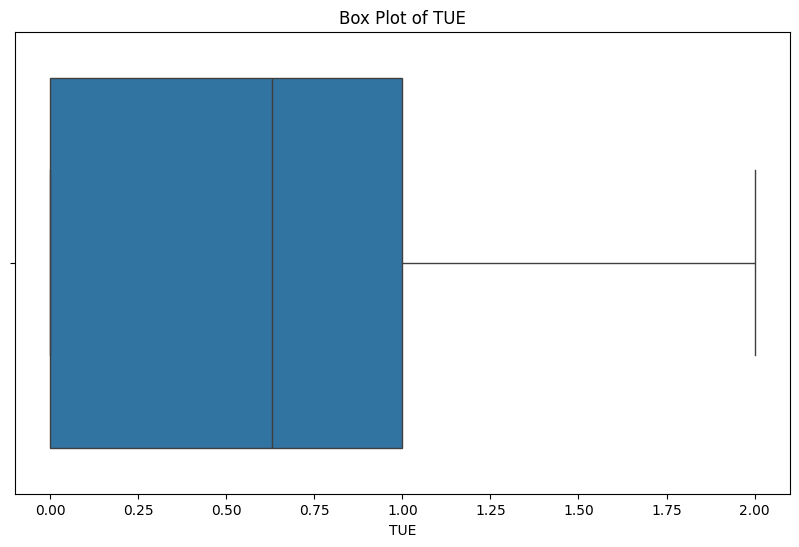

In [10]:
numeric_features = df.select_dtypes(include=[np.number])
for feature in numeric_features:
  plt.figure(figsize=(10,6))
  sns.boxplot(x=df[feature])
  plt.title(f"Box Plot of {feature}")
  plt.show()

# **3. EDA**

## 3.1 Heatmap

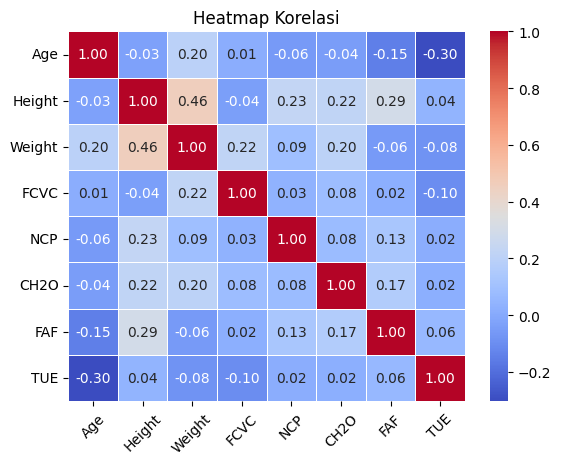

In [11]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(rotation=45)
plt.title('Heatmap Korelasi')
plt.show()

## 3.2 Histogram

### 3.2.1 Histogram pada Data Numerik

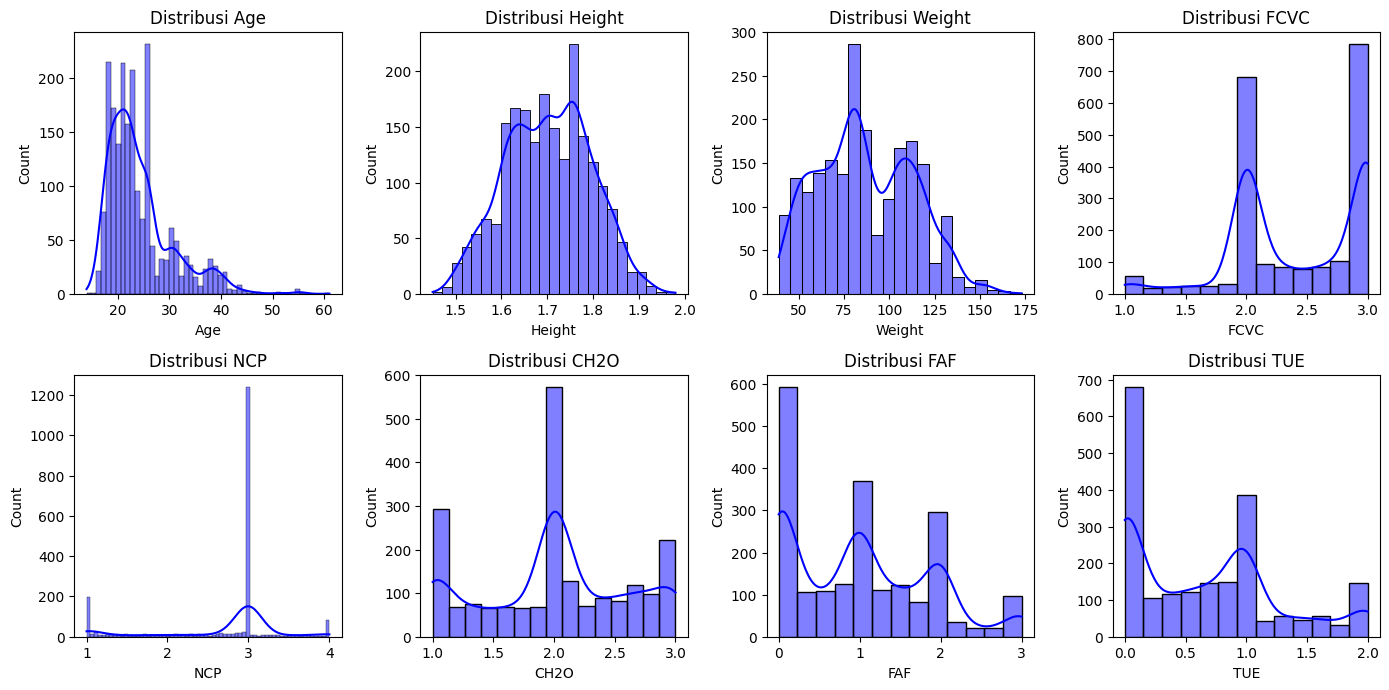

In [12]:
numeric_features = df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
for i, column in enumerate(numeric_features.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[column], kde=True, color='blue')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

### 3.2.2 Histogram pada Data Object

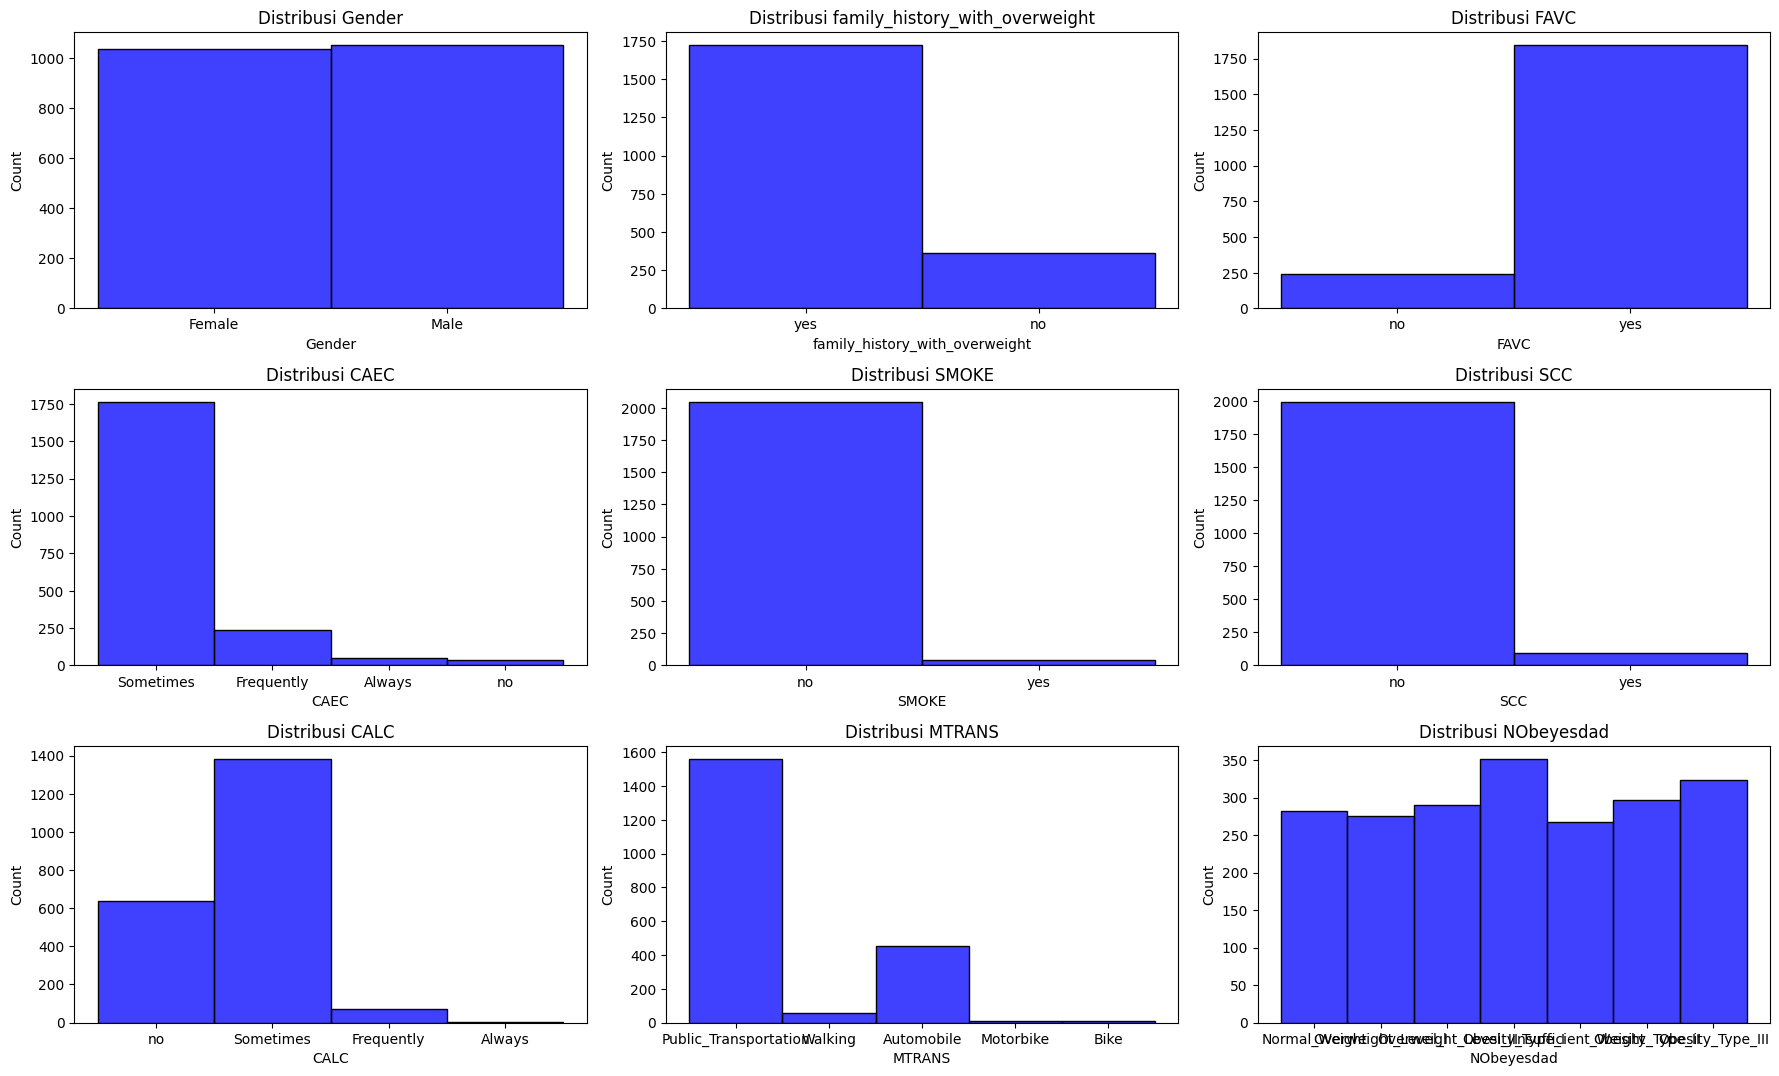

In [13]:
object_features = df.select_dtypes(object)
plt.figure(figsize=(18, 14))
for i, column in enumerate(object_features.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[column], color='blue')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

## 3.3 Hubungan Antara Tinggi dan Berat Badan Berdasarkan Tingkat Obesitas

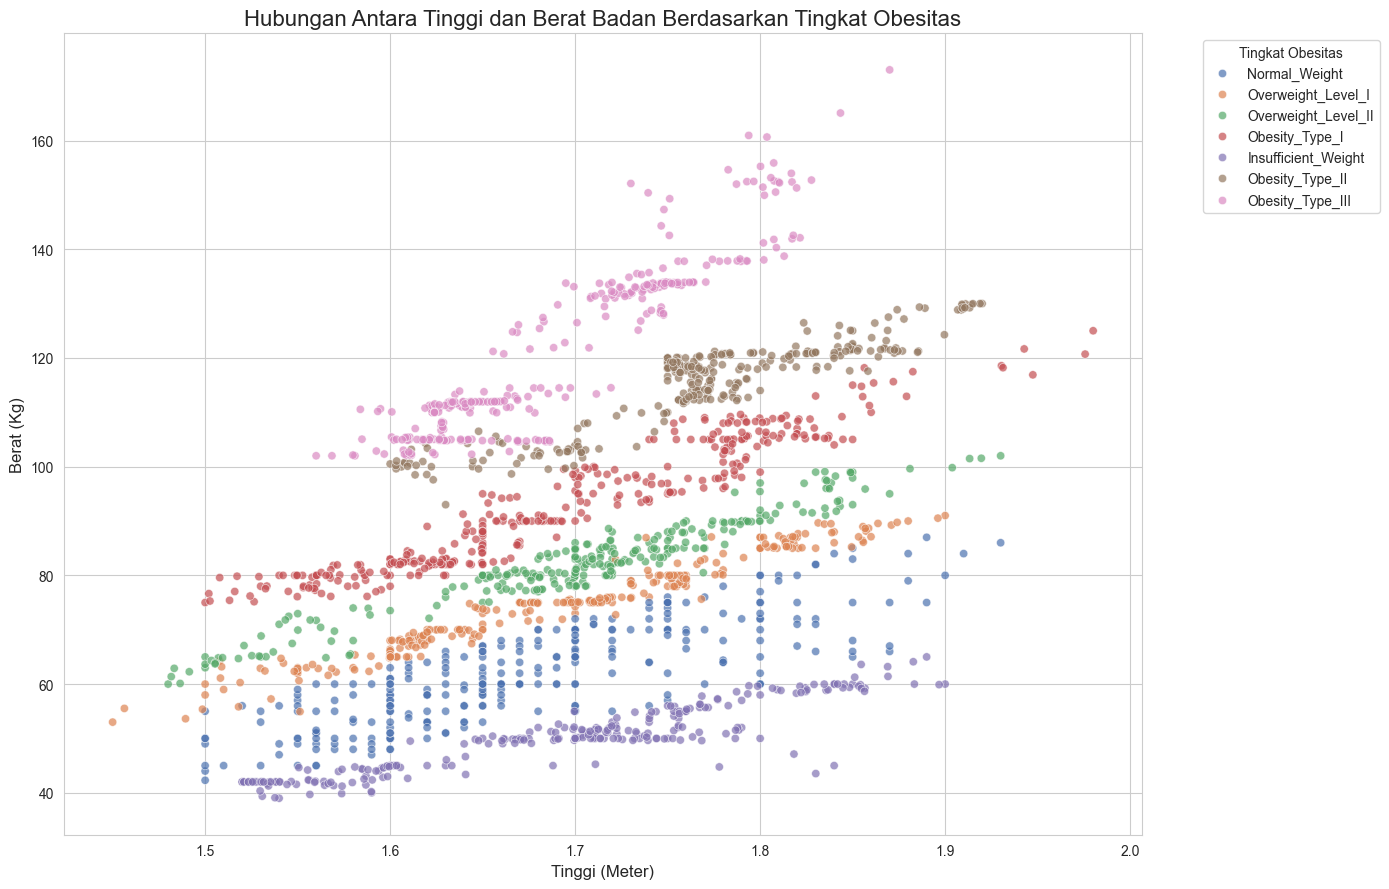

In [14]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 9))
sns.scatterplot(
    x='Height',
    y='Weight',
    hue='NObeyesdad',
    data=df,
    palette='deep',
    alpha=0.7
)

plt.title('Hubungan Antara Tinggi dan Berat Badan Berdasarkan Tingkat Obesitas', fontsize=16)
plt.xlabel('Tinggi (Meter)', fontsize=12)
plt.ylabel('Berat (Kg)', fontsize=12)
plt.legend(title='Tingkat Obesitas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3.4 Distribusi Tingkat Obesitas (NObeyesdad)

C:\Users\Irham\AppData\Local\Temp\ipykernel_11988\1959858859.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['NObeyesdad'], order=df['NObeyesdad'].value_counts().index, palette='viridis')


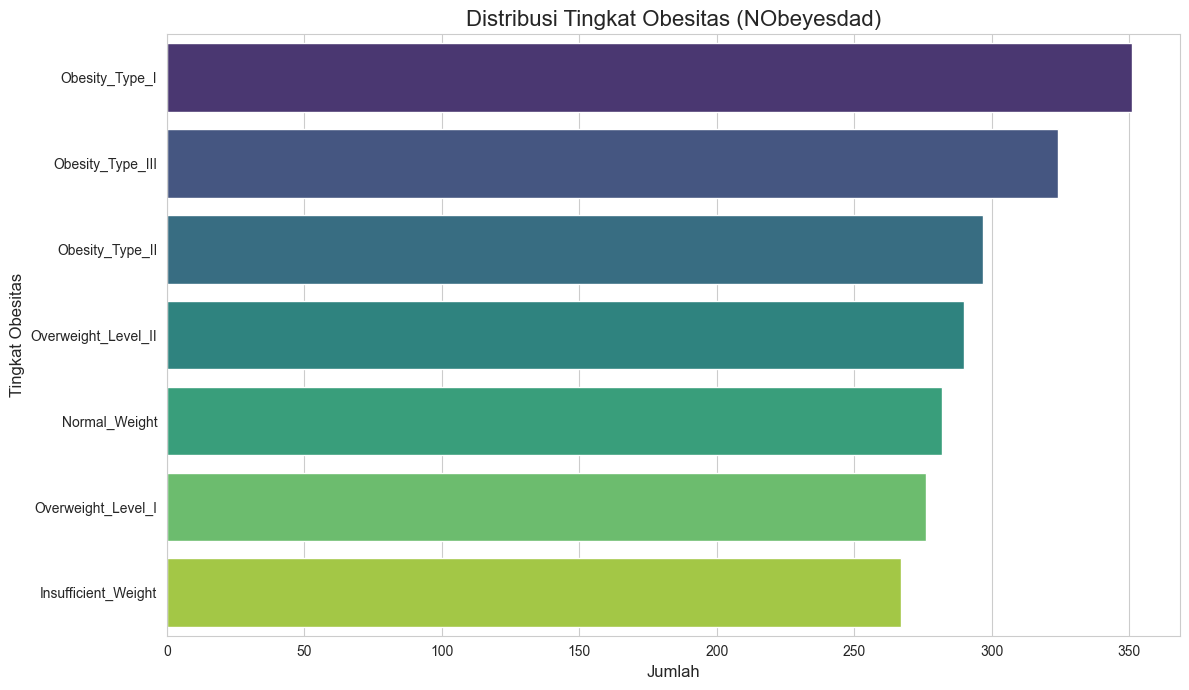

In [15]:
plt.figure(figsize=(12, 7))
sns.countplot(y=df['NObeyesdad'], order=df['NObeyesdad'].value_counts().index, palette='viridis')
plt.title('Distribusi Tingkat Obesitas (NObeyesdad)', fontsize=16)
plt.xlabel('Jumlah', fontsize=12)
plt.ylabel('Tingkat Obesitas', fontsize=12)
plt.tight_layout()
plt.show()

## 3.5 Analisis Variabel Numerik per Kelompok

C:\Users\Irham\AppData\Local\Temp\ipykernel_11988\3007366320.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NObeyesdad', y=column, data=df, order=plot_order, palette='viridis')
C:\Users\Irham\AppData\Local\Temp\ipykernel_11988\3007366320.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NObeyesdad', y=column, data=df, order=plot_order, palette='viridis')
C:\Users\Irham\AppData\Local\Temp\ipykernel_11988\3007366320.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NObeyesdad', y=column, data=df, order=plot_order, palette=

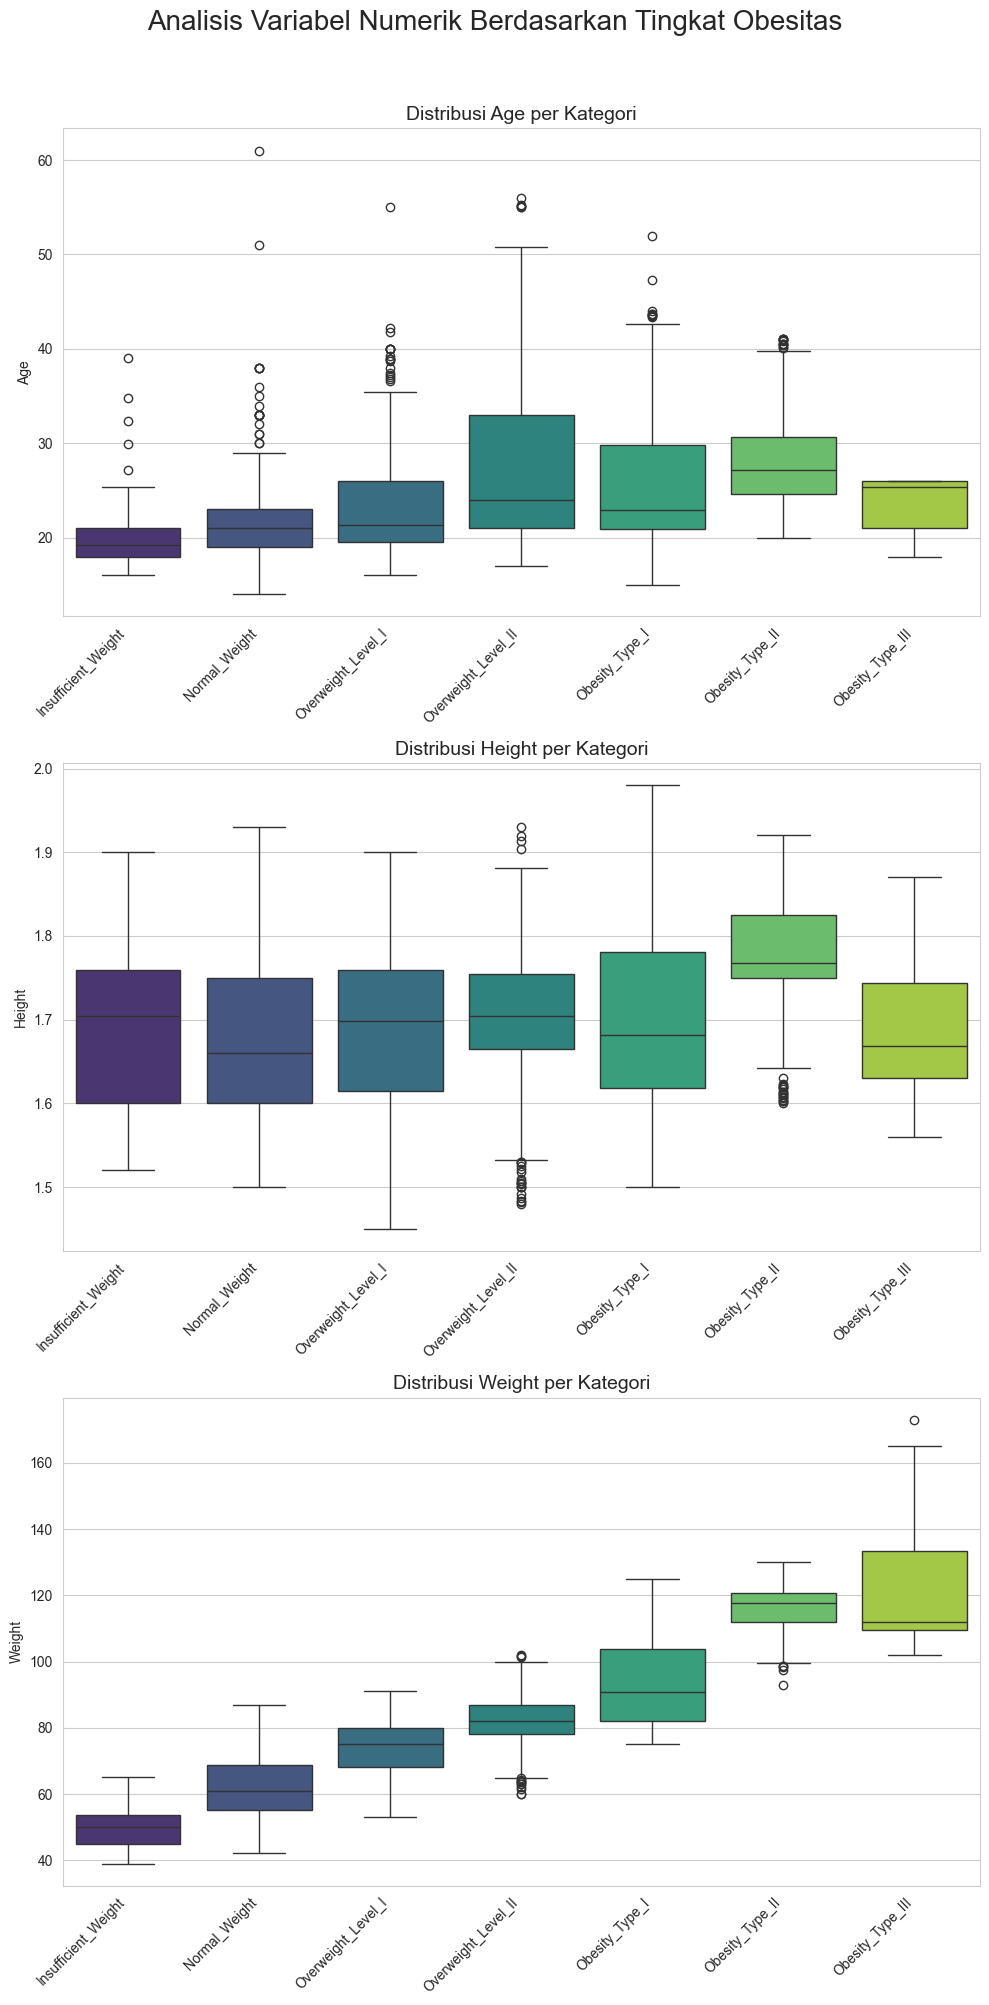

In [16]:
sns.set_style("whitegrid")
plot_order = [
    'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
    'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'
]

# numerical_features = ['Age', 'Height', 'Weight']
numerical_features = ['Age', 'Height', 'Weight']


plt.figure(figsize=(10, 20))
plt.suptitle('Analisis Variabel Numerik Berdasarkan Tingkat Obesitas', fontsize=20, y=1.0)

for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x='NObeyesdad', y=column, data=df, order=plot_order, palette='viridis')
    plt.title(f'Distribusi {column} per Kategori', fontsize=14)
    plt.xlabel('')
    plt.ylabel(f'{column}')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## 3.6 Analisis Variabel Kategorikal per Kelompok

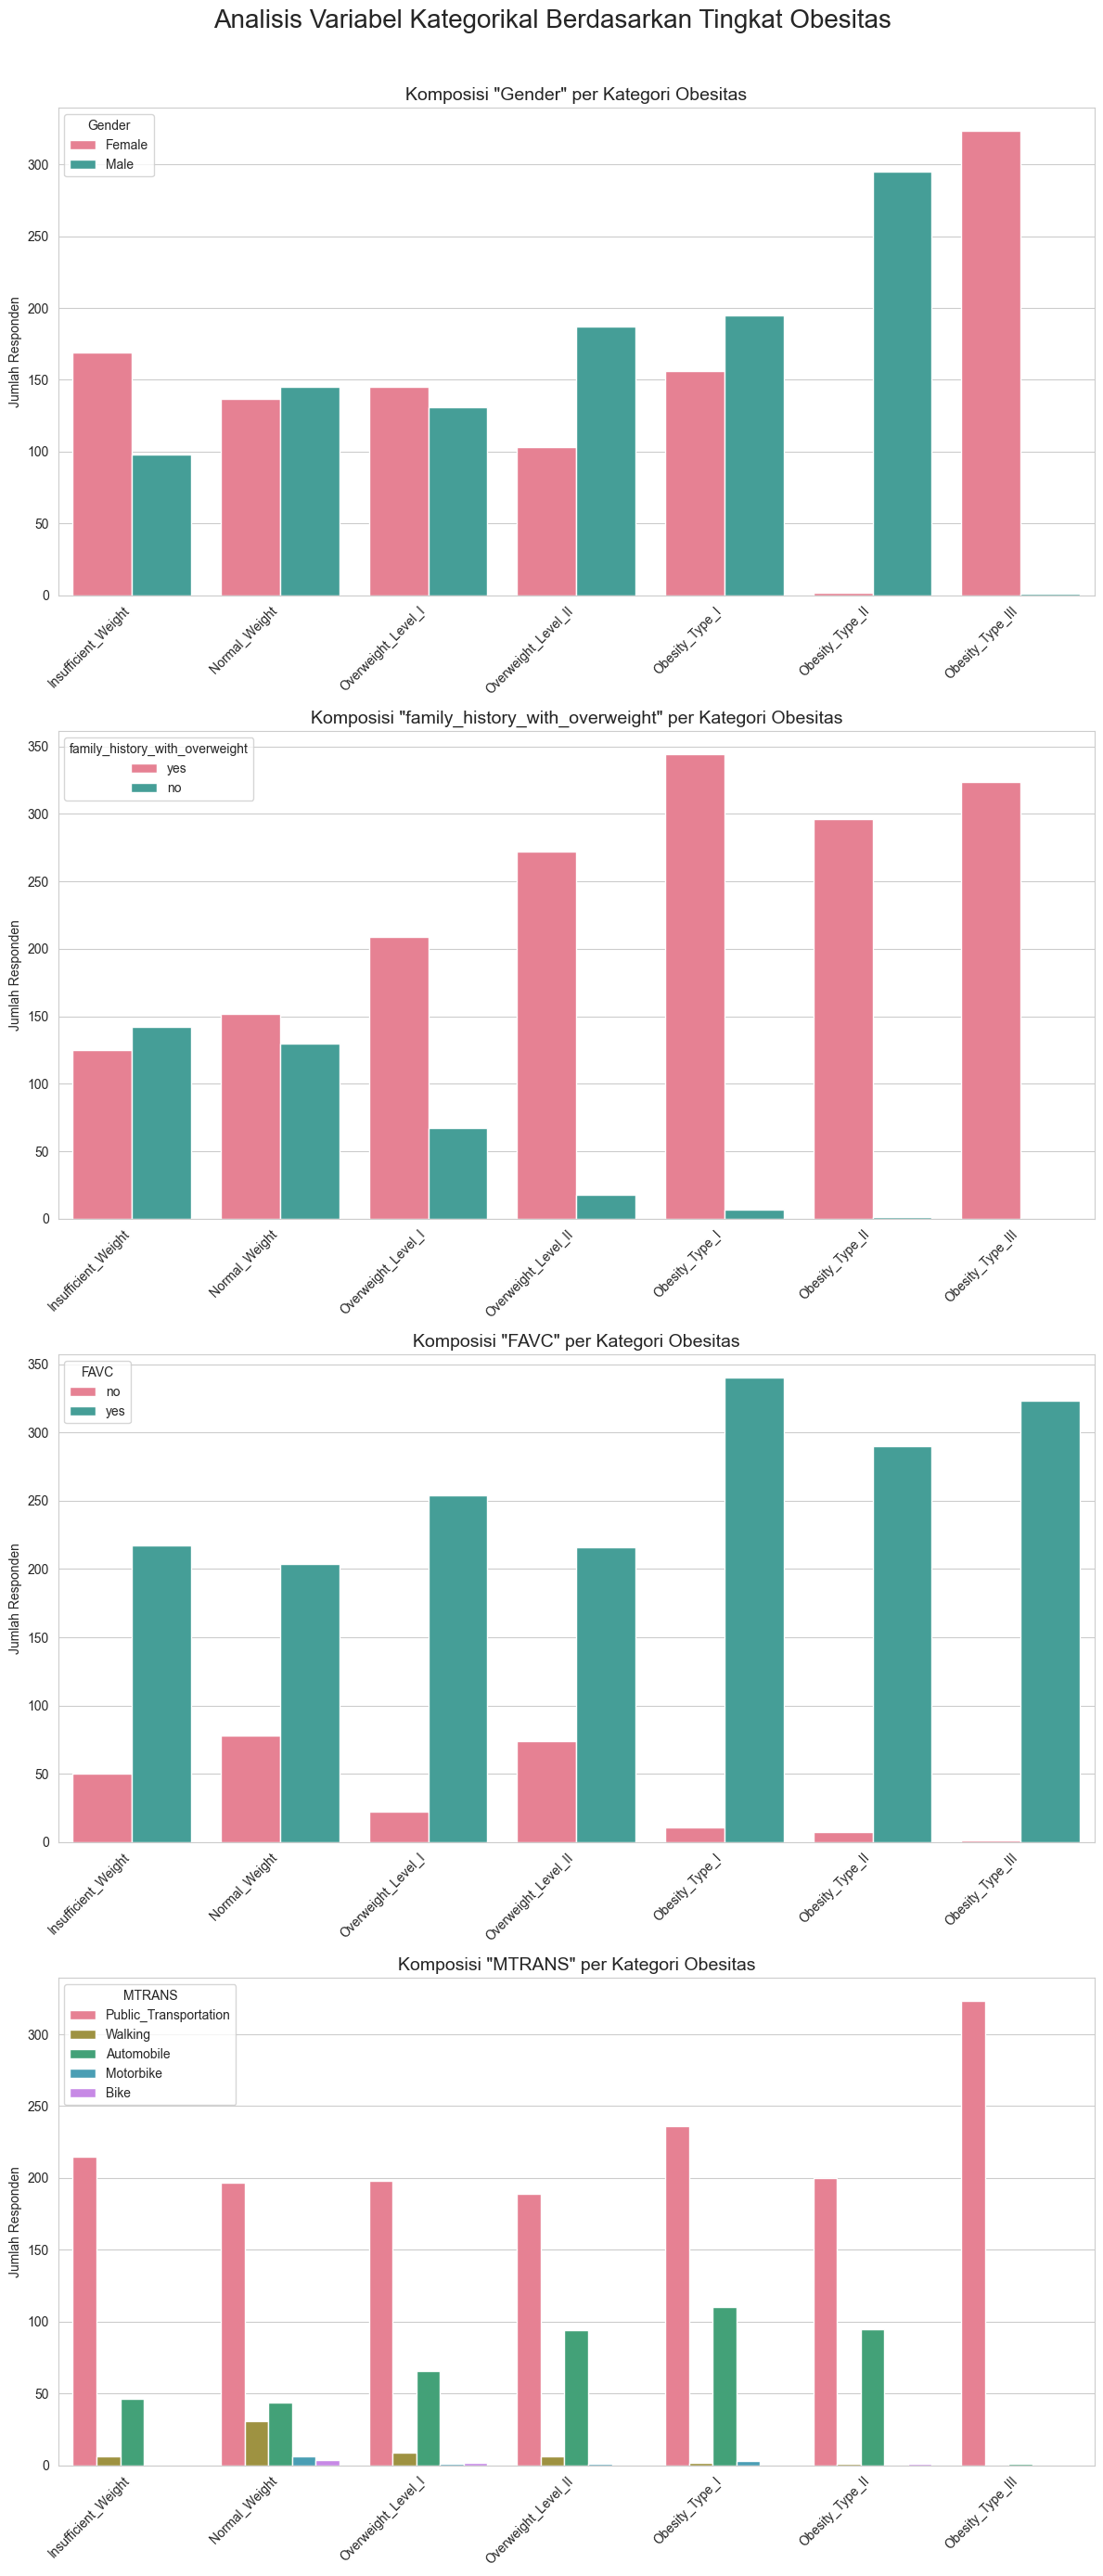

In [17]:
sns.set_style("whitegrid")
plot_order = [
    'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
    'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'
]

categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'MTRANS']

plt.figure(figsize=(12, 28))
plt.suptitle('Analisis Variabel Kategorikal Berdasarkan Tingkat Obesitas', fontsize=20, y=0.99)

for i, column in enumerate(categorical_features, 1):
    plt.subplot(4, 1, i)
    sns.countplot(x='NObeyesdad', hue=column, data=df, order=plot_order, palette='husl')
    plt.title(f'Komposisi "{column}" per Kategori Obesitas', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Jumlah Responden')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=column)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# **4. Data Preparation**

## **4.1 Mengatasi Data Duplikat**

In [18]:
df.drop_duplicates(inplace=True)
print(f"Data duplikat telah berhasil dihapus. Jumlah data duplikat yang tersisa: {df.duplicated().sum()}")

Data duplikat telah berhasil dihapus. Jumlah data duplikat yang tersisa: 0


## **4.2 Feature Engineering**

In [ ]:
drop_features = ['SCC', 'CH2O', 'SMOKE', 'MTRANS', 'CALC', 'TUE', 'family_history_with_overweight']


existing_features = [col for col in drop_features if col in df.columns]

df = df.drop(columns=existing_features)

print("Fitur yang dihapus:", existing_features)
print("Jumlah fitur tersisa:", len(df.columns))
df.head()

Fitur yang dihapus: ['SCC', 'CH2O', 'SMOKE', 'MTRANS', 'TUE', 'family_history_with_overweight']
Jumlah fitur tersisa: 11


,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,FAF,CALC,NObeyesdad
0,Female,21.0,1.62,64.0,no,2.0,3.0,Sometimes,0.0,no,Normal_Weight
1,Female,21.0,1.52,56.0,no,3.0,3.0,Sometimes,3.0,Sometimes,Normal_Weight
2,Male,23.0,1.80,77.0,no,2.0,3.0,Sometimes,2.0,Frequently,Normal_Weight
3,Male,27.0,1.80,87.0,no,3.0,3.0,Sometimes,2.0,Frequently,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,2.0,1.0,Sometimes,0.0,Sometimes,Overweight_Level_II


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      2087 non-null   object 
 1   Age         2087 non-null   float64
 2   Height      2087 non-null   float64
 3   Weight      2087 non-null   float64
 4   FAVC        2087 non-null   object 
 5   FCVC        2087 non-null   float64
 6   NCP         2087 non-null   float64
 7   CAEC        2087 non-null   object 
 8   FAF         2087 non-null   float64
 9   CALC        2087 non-null   object 
 10  NObeyesdad  2087 non-null   object 
dtypes: float64(6), object(5)
memory usage: 195.7+ KB


## **4.3 Scaler**

In [21]:
kolom_numerik = df.select_dtypes(include=['int64', 'float64']).columns
scaler = {}

for col in kolom_numerik:
    scaler[col] = RobustScaler()
    df[col] = scaler[col].fit_transform(df[[col]])

df.head()

,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,FAF,CALC,NObeyesdad
0,Female,-0.303682,-0.585617,-0.454616,no,-0.396265,0.000000,Sometimes,-0.643668,no,Normal_Weight
1,Female,-0.303682,-1.303425,-0.645020,no,0.603735,0.000000,Sometimes,1.287335,Sometimes,Normal_Weight
2,Male,0.025046,0.706438,-0.145209,no,-0.396265,0.000000,Sometimes,0.643668,Frequently,Normal_Weight
3,Male,0.682502,0.706438,0.092796,no,0.603735,0.000000,Sometimes,0.643668,Frequently,Overweight_Level_I
4,Male,-0.139318,0.562876,0.159437,no,-0.396265,-6.610849,Sometimes,-0.643668,Sometimes,Overweight_Level_II


## **4.4 Encoding**

In [22]:
category_features = df.select_dtypes(include=['object', 'category']).columns
category_features = category_features.drop('Gender')

gender = df['Gender']

label_encoder = {}
for col in category_features:
  label_encoder[col] = LabelEncoder()
for col in category_features:
  df[col] = label_encoder[col].fit_transform(df[col])

ohe = OneHotEncoder(sparse_output=False, drop='first')

gender_ohe = ohe.fit_transform(df[['Gender']])

gender_encoded_df = pd.DataFrame(
    gender_ohe,
    columns=ohe.get_feature_names_out(['Gender']),
    index=df.index
)

df = pd.concat([df.drop(columns=['Gender']), gender_encoded_df], axis=1)

df.head()

,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,FAF,CALC,NObeyesdad,Gender_Male
0,-0.303682,-0.585617,-0.454616,0,-0.396265,0.000000,2,-0.643668,3,1,0.0
1,-0.303682,-1.303425,-0.645020,0,0.603735,0.000000,2,1.287335,2,1,0.0
2,0.025046,0.706438,-0.145209,0,-0.396265,0.000000,2,0.643668,1,1,1.0
3,0.682502,0.706438,0.092796,0,0.603735,0.000000,2,0.643668,1,5,1.0
4,-0.139318,0.562876,0.159437,0,-0.396265,-6.610849,2,-0.643668,2,6,1.0


In [23]:
df.columns.tolist()

['Age',
 'Height',
 'Weight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'FAF',
 'CALC',
 'NObeyesdad',
 'Gender_Male']

## **4.5 Data Splitting**

In [24]:
X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(1460, 10), y_train=(1460,)
Test set shape: X_test=(627, 10), y_test=(627,)


# **5. Modeling**

### **5.1 Membangun Model *Decision Tree***

In [25]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train, y_train)

y_pred = model_decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        87
           1       0.91      0.77      0.83        95
           2       0.97      0.93      0.95       105
           3       0.99      0.98      0.98        95
           4       1.00      1.00      1.00        91
           5       0.83      0.86      0.85        80
           6       0.87      0.99      0.92        74

    accuracy                           0.93       627
   macro avg       0.93      0.93      0.93       627
weighted avg       0.93      0.93      0.93       627



### **5.2 Membangun Model *Random Forest***

In [26]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred =model_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94        87
           1       0.90      0.82      0.86        95
           2       0.97      0.97      0.97       105
           3       1.00      0.98      0.99        95
           4       1.00      1.00      1.00        91
           5       0.87      0.90      0.88        80
           6       0.90      0.95      0.92        74

    accuracy                           0.94       627
   macro avg       0.94      0.94      0.94       627
weighted avg       0.94      0.94      0.94       627



# **6. Evaluasi**

### **6.1 Evaluasi Antar Model**

In [27]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1-Score': f1_score(y_test, y_pred, average='macro')
    }

    return results

results = {
    'Decision Tree (DT)': evaluate_model(model_decision_tree, X_test, y_test),
    'Random Forest (RF)': evaluate_model(model_rf, X_test, y_test)
}


summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

rows = []
for model_name, metrics in results.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics['Accuracy'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall'],
        'F1-Score': metrics['F1-Score']
    })

summary_df = pd.DataFrame(rows)

print(summary_df)

                Model  Accuracy  Precision    Recall  F1-Score
0  Decision Tree (DT)  0.929825   0.926775  0.931171  0.927260
1  Random Forest (RF)  0.939394   0.936444  0.938771  0.937182


### **6.2 Confusion Matrix**

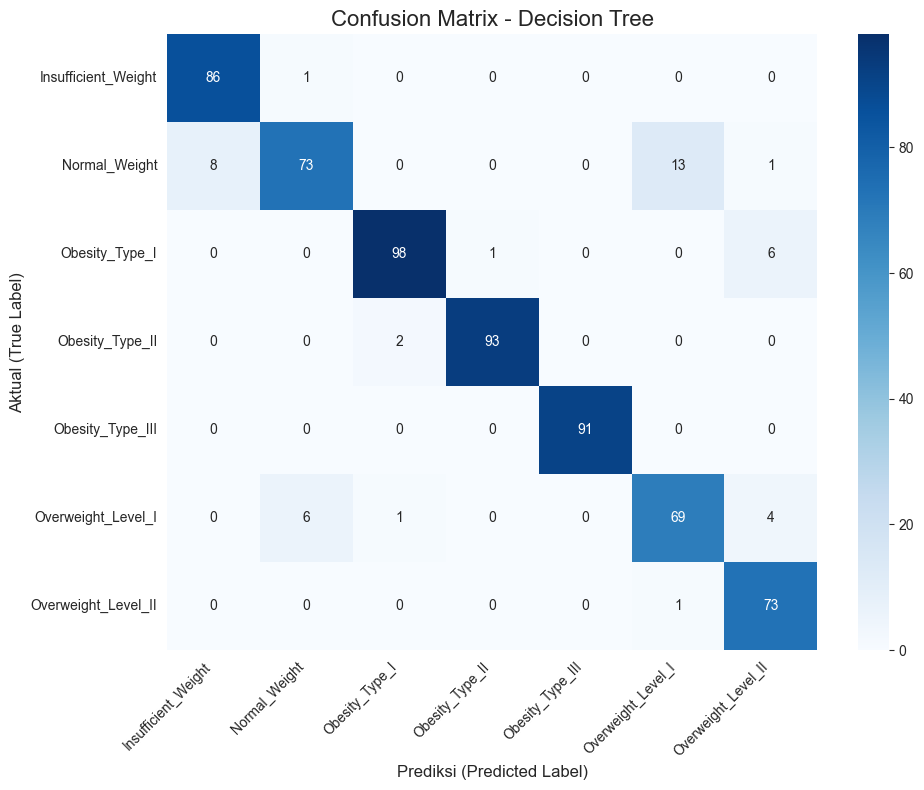

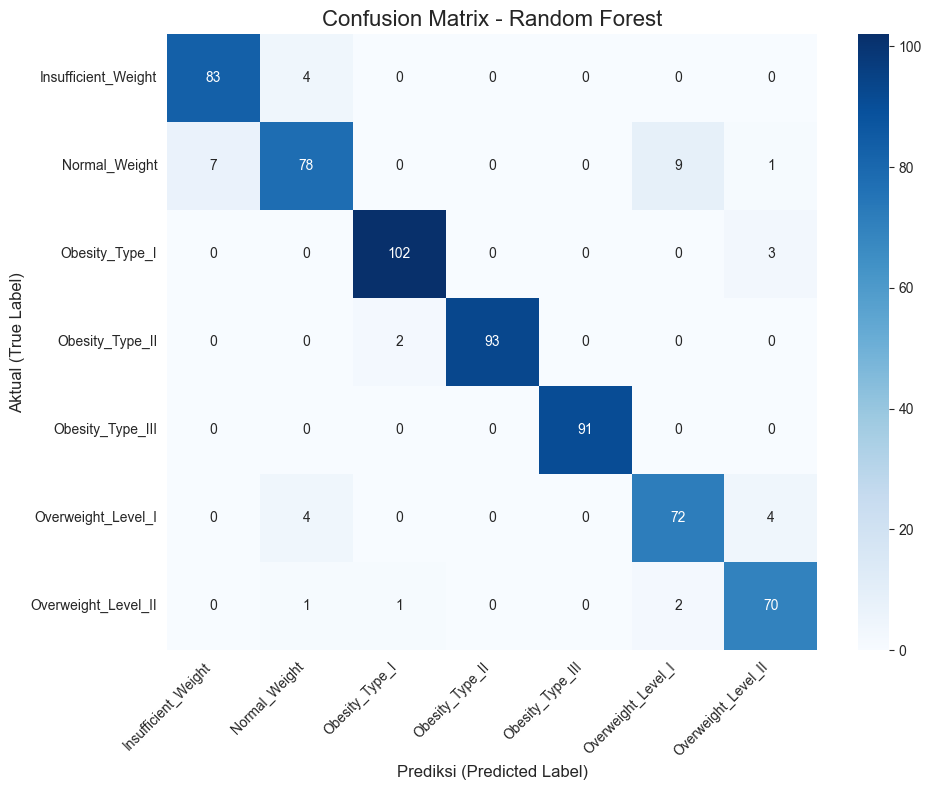

In [28]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    target_names = label_encoder['NObeyesdad'].classes_
    
    # 4. Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.ylabel('Aktual (True Label)', fontsize=12)
    plt.xlabel('Prediksi (Predicted Label)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model_decision_tree, X_test, y_test, 'Decision Tree')

plot_confusion_matrix(model_rf, X_test, y_test, 'Random Forest')

### **6.3 Feature Importance**

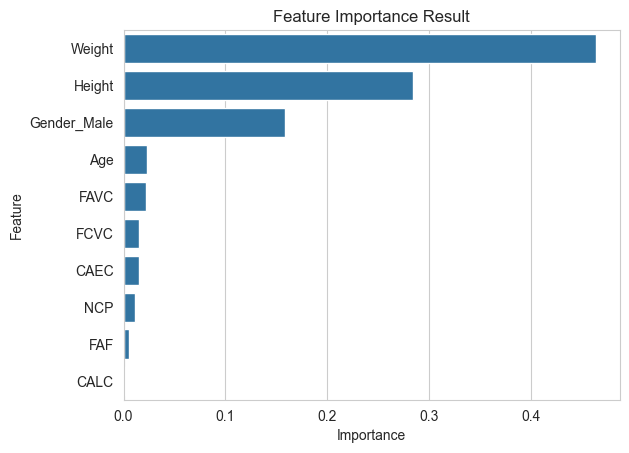

In [29]:
importances = model_decision_tree.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title("Feature Importance Result")
plt.show()

## **7. Deployment**

In [30]:
model_columns = list(X_train.columns)

joblib.dump(ohe, 'ohe_gender.joblib')
joblib.dump(model_rf, 'rf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(model_columns, 'model_columns.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib') 

['label_encoder.joblib']